In [ ]:
# import all the necessary libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import re
import pickle
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix

In [ ]:
training_dir='/content/drive/My Drive/imagesDatabaseHW8/training/'
testing_dir = '/content/drive/My Drive/imagesDatabaseHW8/testing/'

In [ ]:
# function to load images and get class labels
def get_images(dir):
  filenames = os.listdir(dir)
  images = []
  #class labels dictionary
  labels = {'cloudy':0,
            'rain':1,
            'shine':2,
            'sunrise':3
            }
  for filename in filenames:

    image_dir = dir + filename
    img = plt.imread(image_dir)
    
    classname=re.split('(\d+)',filename)[0]
    classlabel = labels[classname]
    images.append([img,classlabel])
  return images

In [ ]:
# get the training and test images
train_images = get_images(training_dir)
test_images = get_images(testing_dir)

In [ ]:
# function to get the gram matrix
def gram_matrix(image, C=16,M=3, K=16):
  # convert to grayscale if not already in
  if len(image.shape)>2:
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  
  #image = cv2.resize(image,(K,K))  #rescaling didnt work out good
  h,w = image.shape
  image = image[h//2-K//2:h//2+K//2,w//2-K//2:w//2+K//2]  #center crop
  #print(image.shape)
  img_vector =[]
  # run for C times to get C channel maps
  for i in range (C):
    # get random kernel
    w = a = np.random.rand(M,M)
    w = w - np.sum(w)/M**2
    filtered_img = cv2.filter2D(image,-1,w)
    filtered_vector = filtered_img.flatten()
    img_vector.append(filtered_vector)
  
  gram_mat = np.zeros ((C,C))
  for i in range(len(img_vector)):
    for j in range(i+1):
    #for j in range(len(img_vector)): #trying to see if full matrix helps improve accuracy but no
      dot = np.dot(img_vector[i],img_vector[j])
      gram_mat[i,j] = dot
  
  return gram_mat

In [ ]:
# full classification pipeline icluding finding gram vectors and classification using SVM

def classification(train_image_list,test_image_list,C,M,K):
  input = np.array([x[0] for x in train_image_list])
  label = [x[1] for x in train_image_list]
  #print(input[0].shape)
  #print(label)

  test_input = [x[0] for x in test_image_list]
  test_label = [x[1] for x in test_image_list]
  train_gram_list=[]
  # get gram matrix for all training images
  for img in input:
    gm = gram_matrix(img,C,M,K)
    gm = np.array(gm).flatten()
    train_gram_list.append(gm)
  #print(train_gram_list)
  test_gram_list=[]
  # get gram matrix for all testing images
  for img in test_input:
    gm = gram_matrix(img,C,M,K)
    gm = np.array(gm).flatten()
    test_gram_list.append(gm)

  ########### Start the Classification task ################
  X_train,X_val,y_train,y_val = train_test_split(train_gram_list,label,test_size = 0.3,shuffle=True)
  X_test,y_test = test_gram_list, test_label

  clf = make_pipeline(StandardScaler(),SVC(C=100,gamma='scale',kernel='rbf'))
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_val)
  acc = accuracy_score(y_val,y_pred)
  y_test_pred = clf.predict(X_test)
  test_acc = accuracy_score(y_test,y_test_pred)
  return acc,test_acc


In [ ]:
#C = [2,4,8,16,32,64,128,256,512]
#M = [3,5,7]
K = [16, 32, 64, 128]
acc_list =[]
test_acc_list =[]
for k in K:
  print("current C=",c)
  acc,test_acc = classification(train_images,test_images,256,3,k)
  acc_list.append(acc)
  test_acc_list.append(test_acc)

current C= 2
current C= 2
current C= 2
current C= 2


In [ ]:
acc,test_acc

(0.3496932515337423, 0.275)

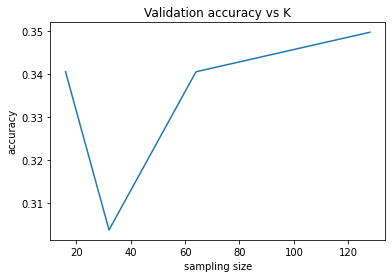

In [ ]:
plt.plot((16,32,64,128),acc_list)
plt.xlabel('sampling size')
plt.ylabel('accuracy')
plt.title('Validation accuracy vs K')
plt.savefig("/content/drive/My Drive/imagesDatabaseHW8/val_acc.jpg")

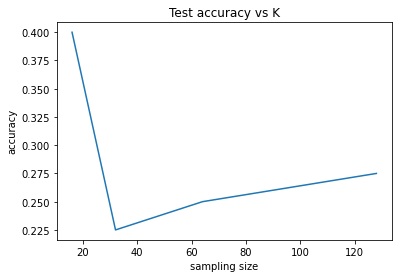

In [ ]:
plt.plot((16,32,64,128),test_acc_list)
plt.xlabel('sampling size')
plt.ylabel('accuracy')
plt.title('Test accuracy vs K')
plt.savefig("/content/drive/My Drive/imagesDatabaseHW8/test_acc.jpg")